In [2]:
%load_ext autoreload
%autoreload 2

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # great plotting library
from pathlib import Path
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests
from natsort import natsorted
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import tifffile

# Load the data, modify these paths to your own
datapath = r"D:\Downloads\241108_N2_RTK_library_forHarrison.xlsx"
savepath = Path(r"D:\Tracking\NucleiTracking\figures\beena")
sample_domino_path = Path(r"D:\Tracking\NucleiTracking\figures\beena\sampledomino.png")

In [109]:
for d in ["domino1", "domino2", "domino3"]:
    dom = plt.imread(savepath / f"{d}.png")
    dom = np.floor(dom * 255).astype(int)
    masks = np.zeros_like(dom)[:, :, 0]
    masks[dom[:, :, 0] == 106] = 1
    masks[dom[:, :, 0] == 213] = 2
    masks[dom[:, :, 0] == 255] = 3
    tifffile.imwrite(savepath / f"{d}_masks.tif", masks)
d_pngs, d_masks = {}, {}
for i in range(1, 4):
    d_pngs[i] = plt.imread(savepath / f"domino{i}.png")
    d_masks[i] = tifffile.imread(savepath / f"domino{i}_masks.tif")

In [130]:
df = pd.read_excel(datapath)

# remove the rows with four or more motifs (ladder)
df = df[df["Motif 4"].isna()]
df = df.reset_index()

# print out the columns
print(df.columns)

"""
Convert the data into vectors representing the presence of motifs
"""
all_motifs = set()

for i in range(1, 9):
    col = f"Motif {i}"
    all_motifs.update(df[col].unique())
    
all_motifs.remove(np.nan)

motifs = natsorted((all_motifs))

motif_index = {motif: i for i, motif in enumerate(motifs)}

rtk_motifs = []
for i, row in df.iterrows():
    rtk_v = []
    for j in range(1, 9):
        motif = row[f"Motif {j}"]
        if pd.isna(motif):
            continue
        rtk_v.append(motif)
    rtk_motifs.append(rtk_v)
#     
# def color_to_int(color):
#     return np.array([color[0]*256, color[1]*256, color[2]*256], dtype=int)

colors = sns.color_palette("pastel", len(motifs))
motif_colors = {motif: color for motif, color in zip(motifs, colors)}

imgs = []

for row in rtk_motifs:
    i = len(row)
    base, mask = d_pngs[i], d_masks[i]
    img = base.copy()
    for j, motif in enumerate(row):
        mask_j = mask == j + 1
        img[mask_j] = motif_colors[motif]
    imgs.append(img)

x_vals = df["delta_FinFout"].values

Index(['index', 'RTK ID', 'Beena Migration? ', 'Motif 1', 'Motif 2', 'Motif 3',
       'Motif 4', 'Motif 5', 'Motif 6', 'Motif 7', 'Motif 8', 'delta_FinFout',
       'pPF050 delta_Finout', 'pBL47_delta_Finout', 'Quant Exp ID'],
      dtype='object')


In [131]:
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
default_zoom = 0.5

class Domino:
    
    def __init__(self, x_target, ax, img, zoom=default_zoom):
        self.x_target = x_target
        self.img = OffsetImage(img, zoom=zoom)
        self.ax = ax
        self.zoom = zoom
        self.extent = self.calculate_extent()
        self.left = x_target - self.extent[0] / 2
        self.right = x_target + self.extent[0] / 2
        
    def update_ax(self, ax):
        self.ax = ax
        self.extent = self.calculate_extent()
        
    def place(self, x, y):
        self.ax.add_artist(AnnotationBbox(self.img, (x, y), frameon=False))
        
    def calculate_extent(self):
        # get the size of the image in axes coordinates
        extent = self.img.get_window_extent(self.ax.figure.canvas.get_renderer())
        
        origin = self.ax.transData.transform((0, 0))
        bl = self.ax.transData.inverted().transform(origin)
        tr = self.ax.transData.inverted().transform((origin[0]+extent.x1, origin[1]+extent.y1))
        
        return tr - bl
    
    def __le__(self, other):
        return self.left <= other.left
    
    def __lt__(self, other):
        return self.left < other.left
    

(96, 32, 3)


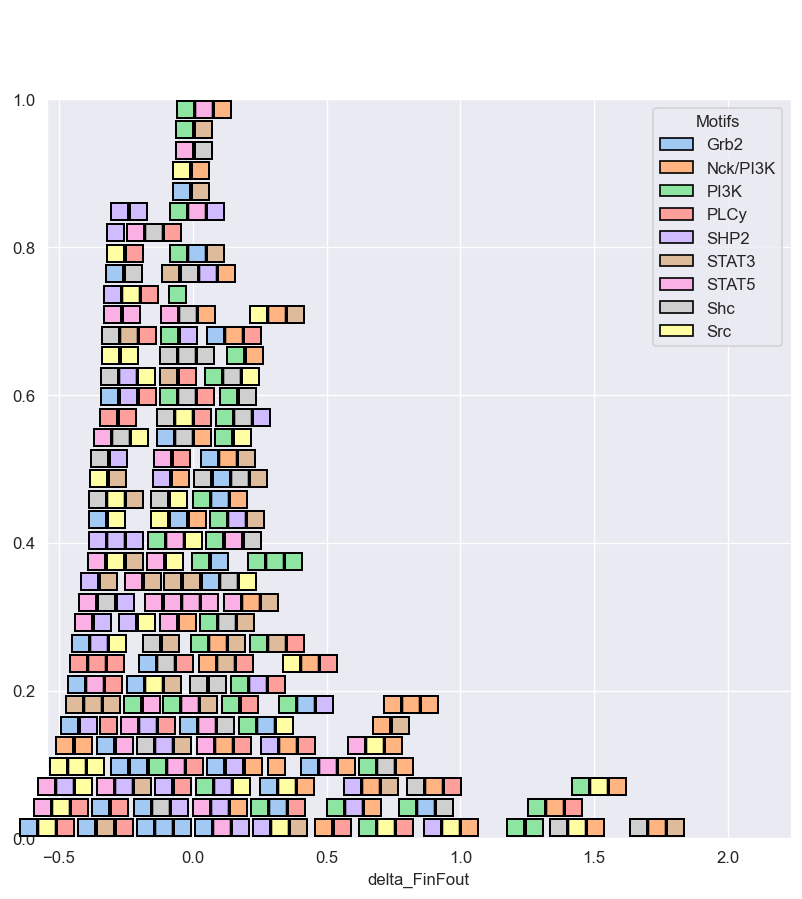

In [139]:

import matplotlib as mpl

# read in sample domino
sample_domino = plt.imread(sample_domino_path)
sample_domino = np.transpose(sample_domino, (1, 0, 2))
print(sample_domino.shape)

mpl.rcParams['figure.dpi'] = 120

fig, ax = plt.subplots(figsize=(8, 8))

x = x_vals
xmin, xmax = min(x), max(x)
ax.set_xlim(xmin, xmax + 0.5)
plt.xlabel("delta_FinFout")

dominos = [Domino(x_target, ax, imgs[i], 0.35) for i, x_target in enumerate(x)]

xmin, xmax = min([d.left for d in dominos]), max([d.right for d in dominos])
ax.set_ylim(0, 1)

for domino in dominos:
    domino.update_ax(ax)
    
unplaced_dominos = dominos.copy()
left = xmin
y = dominos[0].extent[1]*1.1 / 2
while unplaced_dominos:
    right_dominos = sorted([d for d in unplaced_dominos if d.left >= left])
    if not right_dominos:
        left = xmin
        y = y + dominos[0].extent[1]*1.1
        continue
        
    next_d = right_dominos.pop(0)
    next_d.place(next_d.x_target, y)
    left = next_d.left + next_d.extent[0] * 1.03  
   
    unplaced_dominos.remove(next_d)
    
# make legend with all motif colors
legend_elements = [mpl.patches.Patch(facecolor=motif_colors[motif], edgecolor='black', label=motif) for motif in motifs]
ax.legend(handles=legend_elements, loc='upper right', title='Motifs')
    

plt.savefig(savepath / "test.png")
plt.show()